## Problem: tracking stuff across tasks

Whats the big deal? Basically I need to be doing filtering, common mode, all of these preprocessing things on a single recording not on individual chunks. What's the best way for me to do this? Probably put things into spike interface. Okay, so I need to make spike interface recording objects for a given day then do preprocessing on the whole day of recordings not on tiny little chunks. I'm going to move this to a new thang I think that makes the most sense.

Here's my problem. I can either start from the raw binaries, convert to NWB, convert to spikeinterface, then do things. Then I have an entirely parallel procesisng pipeline from the rest of the lab and can't really use everything taht everybody else is using but there's a whole open source community. Or I can make my own thing to do this and hack it together. I don't want to hack it to gether. I am going to implement it from the binaries. AGHGHGHGHGHGHGGHGHGHGHGHGHGHG

## Imports and functions

In [2]:

# From anywhere in your project
#python
import aopy_nwb_conv

print(aopy_nwb_conv.__file__)
# Should show: .../src/aopy_nwb_conv/__init__.py

/home/aolab/aj/aopy_nwb_conv/src/aopy_nwb_conv/__init__.py


In [ ]:

import os
import re
from datetime import datetime

import numpy as np
import spikeinterface
import spikeinterface as si  # import core only
import spikeinterface.extractors as se
from aopy.data import db
from aopy.data.bmi3d import load_ecube_metadata
from matplotlib import pyplot as plt
from neuroconv.datainterfaces import WhiteMatterRecordingInterface

#import spikeinterface.postprocessing as spost
#import spikeinterface.qualitymetrics as sqm
#import spikeinterface.comparison as sc
#import spikeinterface.exporters as sexp
#import spikeinterface.curation as scur
#import spikeinterface.widgets as sw
#from spikeinterface.extractors.nwbextractors import NwbRecordingExtractor
from probeinterface import Probe, ProbeGroup
from probeinterface.plotting import plot_probe, plot_probe_group
from spikeinterface.preprocessing import (
    apply_preprocessing_pipeline,
    bandpass_filter,
    common_reference,
)


def get_datetime_from_raw_path(raw_path):
    filename = raw_path  # Use the parameter, not ecube_file_paths_day[0]
    match = re.search(r'(\d{4}-\d{2}-\d{2}_\d{2}-\d{2}-\d{2})', filename)

    if match:
        datetime_str = match.group(1)
        dt = datetime.strptime(datetime_str, "%Y-%m-%d_%H-%M-%S")
        return dt
    else:
        raise ValueError(
            f"No datetime found in filename: '{filename}'. "
            f"Expected format: YYYY-MM-DD_HH-MM-SS"
        )

## Identify day
My core goal here is to convert a day's worth of recordings into a single recording object that I can then do preprocessing on elegantly with the spikeinterface.

In [2]:

subject = 'churro'
#Relevant dates of recordings
dates = ('2025-08-05', '2025-08-06')
#Raw Data directory
data_dir = '/media/moor-data/raw'
#Preprocessed data directory
preproc_dir = '/media/moor-data/preprocessed'

entries = db.lookup_sessions(subject=subject, date=dates, filter_fn=db.filter_has_neural_data('ecog'))

df = db.summarize_entries(entries)

## Probe info Revisit and improve

(2, 36)


/tmp/ipykernel_3150802/1868603459.py:33: DeprecationWarning: `plot_probe_group` is deprecated and will be removed in 2.23. Use plot_probegroup instead
  plot_probe_group(probegroup, same_axes=True)
/tmp/ipykernel_3150802/1868603459.py:34: DeprecationWarning: `plot_probe_group` is deprecated and will be removed in 2.23. Use plot_probegroup instead
  plot_probe_group(probegroup, same_axes=False, with_contact_id=True)


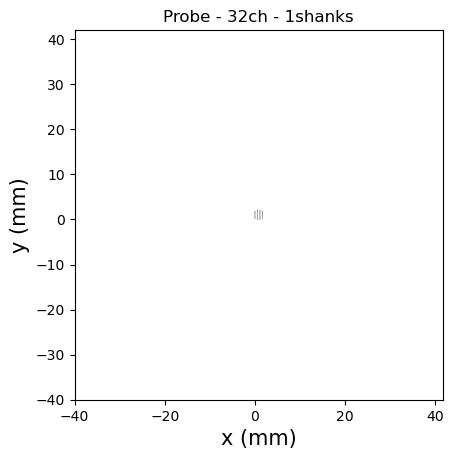

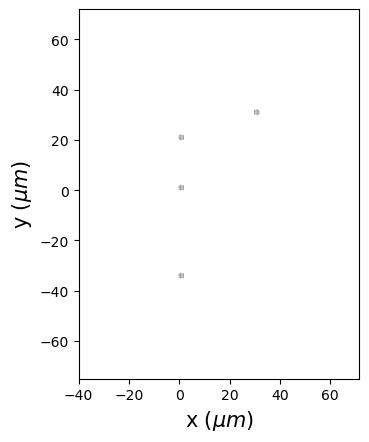

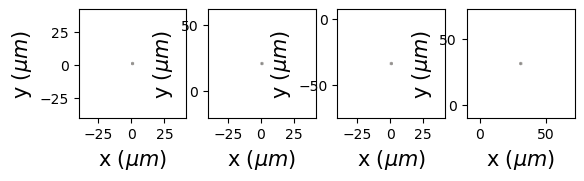

In [3]:
#Probe stuff here
x = np.repeat(np.arange(0,4), 9)/1.8
y = np.tile(np.arange(0,9),4)/4.0

positions = np.vstack([x,y])
print(positions.shape)
indices_to_keep = [i not in [0,8,27,35] for i in range(positions.shape[1])]
positions = positions[:,indices_to_keep]
positions

probe = Probe(ndim=2, si_units='mm')
probe.set_contacts(positions=positions.T, shapes='circle', shape_params={'radius': 0.05})

plot_probe(probe, )

fef = probe.copy()
pmd = probe.copy()
pmd.move([0, 20])
pmv = probe.copy()
pmv.move([0, -35])
m1 = probe.copy()
m1.move([30,30])

probegroup = ProbeGroup()

probegroup.add_probe(fef)
probegroup.add_probe(pmd)
probegroup.add_probe(pmv)
probegroup.add_probe(m1)

probegroup.set_global_device_channel_indices(np.arange(0,128))

plot_probe_group(probegroup, same_axes=True)
plot_probe_group(probegroup, same_axes=False, with_contact_id=True)

plt.show()



## Compile the day's recording into a single recording object

In [4]:
ecube_file_paths_day = []

for entry in entries:
    files = entry.get_raw_files()
    ecube_path = files['ecube']
    full_ecube_path = os.path.join(data_dir, ecube_path)
    ecube_metadata = load_ecube_metadata(full_ecube_path, "Headstages")
    volts_per_bit = ecube_metadata['voltsperbit']
    file_names = [x for x in os.listdir(full_ecube_path) if 'Headstages_128' in x]
    file_path = [os.path.join(full_ecube_path, x) for x in file_names]
    ecube_file_paths_day.append(file_path)

In [5]:
sampling_frequency = 25_000.0
num_channels = 128
dtype='int16'

day_tmp = []
for task_paths in ecube_file_paths_day:
   task_tmp = []
   for f in task_paths:
      task_tmp.append(se.read_binary(f, sampling_frequency=sampling_frequency, dtype='int16', num_channels=128, gain_to_uV=volts_per_bit))
   day_tmp.append(si.concatenate_recordings(task_tmp))

day_rec = si.append_recordings(day_tmp)
day_rec = day_rec.set_probegroup(probegroup)
print(day_rec)
day_rec.set_channel_gains(volts_per_bit)
day_rec.set_channel_offsets(0)


AppendSegmentRecording: 128 channels - 25.0kHz - 7 segments - 131,031,832 samples 
                        5,241.27s (1.46 hours) - int16 dtype - 31.24 GiB
Segments:
Samples:   12,546,864 | 8,375,000 | 17,650,000 | ... | 19,525,000 | 35,309,968 | 13,175,000
Durations: 501.87s (8.36 minutes) | 335.00s (5.58 minutes) | 706.00s (11.77 minutes) | ... | 781.00s (13.02 minutes) | 1,412.40s (23.54 minutes) | 527.00s (8.78 minutes)
Memory:    2.99 GiB | 2.00 GiB | 4.21 GiB | ... | 4.66 GiB | 8.42 GiB | 3.14 GiB


## Now to see if I can do some preprocessing!!!

In [6]:

# recording is a RecordingExtractor object
recording_f = bandpass_filter(recording=day_rec, freq_min=300, freq_max=6000)
recording_cmr = common_reference(recording=recording_f, operator="median")

traces = recording_cmr.get_traces(segment_index=0, start_frame=100_000, end_frame=200_000)



In [7]:

preprocessing_dict = {
    'bandpass_filter': {'freq_min': 250, 'freq_max':6000, 'dtype':'float32'},
    'common_reference': {'operator': 'median', 'reference':'global'},
    'detect_and_remove_bad_channels': {},
}

preprocessed_recording = apply_preprocessing_pipeline(day_rec, preprocessing_dict)

In [22]:
import spikeinterface.widgets as sw

w = sw.plot_traces(recording=preprocessed_recording, segment_index=0, backend="ipywidgets")



AssertionError: To use the 'ipywidgets' backend, you have to set %matplotlib widget

In [30]:
my_nwbfile = "/home/aolab/aj/nwb/tmp.nwb"

from neuroconv.tools import spikeinterface

# For this data interface we need to pass the file_path with the location of the data
file_path = ecube_file_paths_day[0][0]
# Change the file_path to the location of the data in your system
sampling_frequency = 25_000.0
num_channels = 64
interface = WhiteMatterRecordingInterface(
   file_path=file_path,
   sampling_frequency=sampling_frequency,
   num_channels=num_channels,
)

# Extract what metadata we can from the source files
metadata = interface.get_metadata()
#session_start_time is required for conversion. If it cannot be inferred
# automatically from the source files you must supply one.
session_start_time = get_datetime_from_raw_path(file_path)
metadata["NWBFile"].update(session_start_time=session_start_time)

 # Choose a path for saving the nwb file and run the conversion
#nwbfile_path = f"{path_to_save_nwbfile}"  # This should be something like: "./saved_file.nwb"
#interface.run_conversion(nwbfile_path=nwbfile_path, metadata=metadata, overwrite=True)

In [31]:

spikeinterface.write_recording_to_nwbfile(recording=preprocessed_recording, nwbfile_path=my_nwbfile, metadata=metadata )


/home/aolab/miniconda3/envs/aj_analysis/lib/python3.12/site-packages/pynwb/file.py:492: UserWarning: Date is missing timezone information. Updating to local timezone.
  args_to_set['session_start_time'] = _add_missing_timezone(session_start_time)


,location,group,group_name,channel_name,rel_x,rel_y
id,,,,,,
0,unknown,0 pynwb.ecephys.ElectrodeGroup at 0x139789213930160\nFields:\n description: no description\n device: DeviceEcephys pynwb.device.Device at 0x139789051330736\nFields:\n description: no description\n\n location: unknown\n,0,0,0.0,0.25
1,unknown,0 pynwb.ecephys.ElectrodeGroup at 0x139789213930160\nFields:\n description: no description\n device: DeviceEcephys pynwb.device.Device at 0x139789051330736\nFields:\n description: no description\n\n location: unknown\n,0,1,0.0,0.50
2,unknown,0 pynwb.ecephys.ElectrodeGroup at 0x139789213930160\nFields:\n description: no description\n device: DeviceEcephys pynwb.device.Device at 0x139789051330736\nFields:\n description: no description\n\n location: unknown\n,0,2,0.0,0.75
3,unknown,0 pynwb.ecephys.ElectrodeGroup at 0x139789213930160\nFields:\n description: no description\n device: DeviceEcephys pynwb.device.Device at 0x139789051330736\nFields:\n description: no description\n\n location: unknown\n,0,3,0.0,1.00
,location,group,group_name,channel_name,rel_x,rel_y
id,,,,,,
0,unknown,0 pynwb.ecephys.ElectrodeGroup at 0x139789213930160\nFields:\n description: no description\n device: DeviceEcephys pynwb.device.Device at 0x139789051330736\nFields:\n description: no description\n\n location: unknown\n,0,0,0.0,0.25
1,unknown,0 pynwb.ecephys.ElectrodeGroup at 0x139789213930160\nFields:\n description: no description\n device: DeviceEcephys pynwb.device.Device at 0x139789051330736\nFields:\n description: no description\n\n location: unknown\n,0,1,0.0,0.50
2,unknown,0 pynwb.ecephys.ElectrodeGroup at 0x139789213930160\nFields:\n description: no description\n device: DeviceEcephys pynwb.device.Device at 0x139789051330736\nFields:\n description: no description\n\n location: unknown\n,0,2,0.0,0.75


In [ ]:
from pynwb import NWBHDF5IO

with NWBHDF5IO(my_nwbfile, "r") as io:
    read_nwbfile = io.read()
    x = read_nwbfile.acquisition['ElectricalSeriesRaw5'].data[:]
    print(x)
    #print(read_nwbfile.acquisition["ElectricalSeries"])
    #print(read_nwbfile.processing["ecephys"])
    #print(read_nwbfile.processing["ecephys"]["LFP"])
    #print(read_nwbfile.processing["ecephys"]["LFP"]["ElectricalSeries"])41

[[-7.8534639e-01 -7.0466721e-01 -4.6304398e+00 ...  3.3663867e+00
   6.6986294e+00  2.7370656e+00]
 [-1.1323510e+04 -1.3340815e+03 -7.7081244e+02 ...  2.7172065e+00
  -2.0358067e+01  1.0261894e+01]
 [-1.5710616e+04 -1.8523317e+03 -1.1012645e+03 ... -5.4881091e+00
  -2.6081173e+01  8.1194848e-01]
 ...
 [-3.1820148e+01  2.5285599e+01  3.6509819e+00 ... -7.4029938e+01
   5.2482693e+01 -1.4873161e+00]
 [-2.5065140e+01  2.2697212e+01  1.3043232e+00 ... -6.0114937e+01
   3.8241264e+01  6.8383827e+00]
 [-3.3325477e+00  5.9326720e+00  7.3903708e+00 ... -7.8473325e+00
  -3.1352615e+00 -1.5959096e+00]]
